## IMPORTS

In [24]:
import tifffile
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
from ultralytics import SAM
from pathlib import Path
import torch
from codecarbon import EmissionsTracker
from datetime import datetime
import csv

/home/thorrut/Documents/Funeria/test-funeria-env/.pixi/envs/default/lib/python3.10/site-packages/codecarbon/input.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


## PARAMETRES

In [3]:

GRID_STRIDE   = 64                   # densité des points
POINTS_PER_CALL = 30                # taille des chunks envoyés à SAM
MIN_AREA      = 300                  # aire min d’un masque (en pixels)
CONF_THR      = 0.35                 #  seuil min confiance de SAM
DEDUP_IOU_THR = 0.90                 # seuil de dé-duplication
MIN_MASK_REGION_AREA = 200
IMAGE_3D_PATH = "../data/Romane_Martin_urne_sature_10-4.tif"
SAM_WEIGHTS = "../data/sam_b.pt"   #path sam en local ou bien download from ultralytics
POINT_LABEL = 1


## UTILS

In [4]:
def make_grid_points(h, w, stride, label=1):
    xs = np.arange(stride // 2, w, stride)
    ys = np.arange(stride // 2, h, stride)
    pts = [(int(x), int(y)) for y in ys for x in xs]  # (x, y)
    lbls = [label] * len(pts)
    return pts, lbls

def dedup_by_iou(masks, iou_thr=0.9, min_area=0):
    keep = []
    for m in masks:
        if m.sum() < min_area:
            continue
        if any( (np.logical_and(m, k).sum() / max(np.logical_or(m, k).sum(), 1)) > iou_thr
                for k in keep ):
            continue
        keep.append(m)
    return keep


def colorize_masks(image_gray, masks_bool, seed=42):

    out = np.dstack([image_gray, image_gray, image_gray]).copy()  # [H, W, 3]
    out = out.astype(np.uint8, copy=False)
    rng = np.random.default_rng(seed)
    for m in masks_bool:
        out[m] = rng.integers(0, 256, size=3, dtype=np.uint8)  # couleur aléatoire (R,G,B)
    return out



## CHARGEMENT DONNEES & MODELE


## chargement données

In [5]:
def to_sam_handled_picture(picture_3D: np.ndarray) -> np.ndarray:
    return np.repeat(picture_3D[..., np.newaxis], 3, -1)

In [7]:
# exemple extraction slice au milieu
vol = tifffile.imread(IMAGE_3D_PATH)
print(f"Volume: shape={vol.shape}, dtype={vol.dtype}")
mid = len(vol) // 2
sl  = vol[mid]

Volume: shape=(1735, 1808, 1595), dtype=uint8


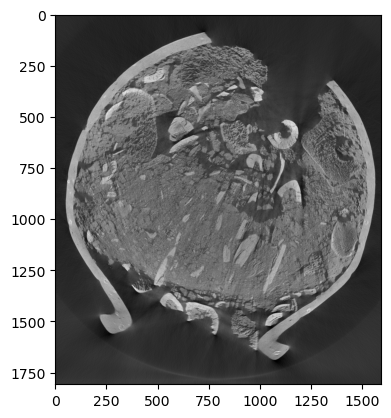

In [10]:
plt.imshow(sl, cmap="gray")
plt.show()

## chargement SAM

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

if not Path(SAM_WEIGHTS).exists():
    print(f"Downloading {SAM_WEIGHTS}...")
    model = SAM(SAM_WEIGHTS)
else:
    print(f"{SAM_WEIGHTS} already exists locally")
    model = SAM(SAM_WEIGHTS)

print("SAM chargé")

Device: cuda
../data/sam_b.pt already exists locally
SAM chargé


## INFERENCE PAR CHUNKS DE POINTS


In [15]:
from typing import Union

def run_sam_chunked_points(model: SAM, image, points: Union[list[tuple[int, int]], int], labels=None,
                           conf=0.35, points_per_call=25, device="cpu", binarize_thr=0.5):
    img = image if image.ndim == 3 else np.dstack([image, image, image])
    # >>>> ???? >>>>
    if img.dtype != np.uint8:
        mn, mx = float(img.min()), float(img.max())
        img = ((img - mn) / (mx - mn) * 255).astype(np.uint8) if mx > mn else np.zeros_like(img, dtype=np.uint8)
    img = np.ascontiguousarray(img)
    # <<<< ???? <<<<
    masks = []
    with torch.inference_mode():
        if isinstance(points, int):
            r = model.predict(source=img, points_stride=points, points_batch_size=points_per_call, conf=conf, device=device)
            if getattr(r, "masks", None) is not None and r.masks is not None:
                t = r.masks.data  # [N,H,W]
                arr = (t > binarize_thr).cpu().numpy()
                masks.extend(mi.astype(bool) for mi in arr)
        else:
            for i in range(0, len(points), points_per_call):
                r = model.predict(source=img,
                                  points=points[i:i+points_per_call],
                                  labels=labels[i:i+points_per_call],
                                  conf=conf, device=device)[0]
                if getattr(r, "masks", None) is not None and r.masks is not None:
                    t = r.masks.data  # [N,H,W]
                    arr = (t > binarize_thr).cpu().numpy()
                    masks.extend(mi.astype(bool) for mi in arr)
        if device == "cuda":
            torch.cuda.empty_cache()
    return masks # non dédupliqués


### grille de points et inférence

In [16]:
type(sl)

numpy.ndarray

In [26]:
tracker = EmissionsTracker()
tracker.start()
H, W = sl.shape[:2]
points, labels = make_grid_points(H, W, GRID_STRIDE, label=POINT_LABEL)
print(f"Points de grille: {len(points)}  (stride={GRID_STRIDE})")

[codecarbon INFO @ 13:14:12] [setup] RAM Tracking...
[codecarbon INFO @ 13:14:12] [setup] GPU Tracking...
[codecarbon INFO @ 13:14:12] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 13:14:12] [setup] CPU Tracking...
[codecarbon WARNING @ 13:14:12] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 13:14:13] We saw that you have a Intel(R) Xeon(R) W-1270 CPU @ 3.40GHz but we don't know it. Please contact us.
[codecarbon INFO @ 13:14:13] CPU Model on constant consumption mode: Intel(R) Xeon(R) W-1270 CPU @ 3.40GHz
[codecarbon INFO @ 13:14:13] >>> Tracker's metadata:
[codecarbon INFO @ 13:14:13]   Platform system: Linux-6.14.0-33-generic-x86_64-with-glibc2.39
[codecarbon INFO @ 13:14:13]   Python version: 3.10.19
[codecarbon INFO @ 13:14:13]   CodeCarbon version: 2.2.2
[codecarbon INFO @ 13:14:13]   Available RAM : 31.086 GB
[codecarbon INFO @ 13:14:13]   CPU count: 16
[codecarbon INFO @ 13:14:13]   CPU model: Intel(R) Xeon(R) W-1270 CPU @ 3.40GHz
[cod

Points de grille: 700  (stride=64)


In [27]:
raw_masks = run_sam_chunked_points(model, sl, points, labels, conf=CONF_THR,points_per_call=POINTS_PER_CALL, device=device)


0: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1 9, 1 10, 1 11, 1 12, 1 13, 1 14, 1 15, 1 16, 1 17, 1 18, 1 19, 1 20, 1 21, 1 22, 1 23, 1 24, 1 25, 1 26, 1 27, 1 28, 1 29, 304.8ms
Speed: 14.1ms preprocess, 304.8ms inference, 5.8ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1 9, 1 10, 1 11, 1 12, 1 13, 1 14, 1 15, 1 16, 1 17, 1 18, 1 19, 1 20, 1 21, 1 22, 1 23, 1 24, 1 25, 1 26, 1 27, 1 28, 1 29, 300.9ms
Speed: 5.3ms preprocess, 300.9ms inference, 5.8ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1 9, 1 10, 1 11, 1 12, 1 13, 1 14, 1 15, 1 16, 1 17, 1 18, 1 19, 1 20, 1 21, 1 22, 1 23, 1 24, 1 25, 1 26, 1 27, 1 28, 1 29, 302.4ms
Speed: 5.3ms preprocess, 302.4ms inference, 5.8ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1 9, 1 10, 1 11, 1 12, 1 13, 1 14, 1 15, 1 16, 1 17, 1 18, 1 19,

[codecarbon INFO @ 13:14:31] Energy consumed for RAM : 0.000049 kWh. RAM Power : 11.657401084899902 W
[codecarbon INFO @ 13:14:31] Energy consumed for all GPUs : 0.000601 kWh. Total GPU Power : 144.31900000000002 W
[codecarbon INFO @ 13:14:31] Energy consumed for all CPUs : 0.000177 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:14:31] 0.000827 kWh of electricity used since the beginning.


0: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1 9, 1 10, 1 11, 1 12, 1 13, 1 14, 1 15, 1 17, 1 18, 1 19, 1 20, 1 21, 1 22, 1 23, 1 24, 1 25, 1 26, 1 27, 1 28, 1 29, 302.9ms
Speed: 5.4ms preprocess, 302.9ms inference, 5.7ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1 9, 1 10, 1 11, 1 12, 1 13, 1 14, 1 15, 1 16, 1 17, 1 18, 1 19, 1 20, 1 21, 1 22, 1 23, 1 24, 1 25, 1 26, 1 27, 1 28, 1 29, 302.8ms
Speed: 5.5ms preprocess, 302.8ms inference, 5.7ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1 9, 1 10, 1 11, 1 12, 1 13, 1 14, 1 15, 1 16, 1 17, 1 18, 1 19, 1 20, 1 21, 1 22, 1 23, 1 24, 1 25, 1 26, 1 27, 1 28, 1 29, 302.2ms
Speed: 5.3ms preprocess, 302.2ms inference, 5.8ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1 9, 1 10, 1 11, 1 12, 1 13, 1 14, 1 15, 1 16, 1 17, 1 18, 1 19, 1 20, 1

In [28]:
masks = dedup_by_iou(raw_masks, iou_thr=DEDUP_IOU_THR, min_area=MIN_AREA)
print(f" {len(masks)} masques après filtrage & dé-dup")

[codecarbon INFO @ 13:14:46] Energy consumed for RAM : 0.000097 kWh. RAM Power : 11.657401084899902 W
[codecarbon INFO @ 13:14:46] Energy consumed for all GPUs : 0.000746 kWh. Total GPU Power : 34.76500000000001 W
[codecarbon INFO @ 13:14:46] Energy consumed for all CPUs : 0.000354 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:14:46] 0.001198 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:15:01] Energy consumed for RAM : 0.000146 kWh. RAM Power : 11.657401084899902 W
[codecarbon INFO @ 13:15:01] Energy consumed for all GPUs : 0.000804 kWh. Total GPU Power : 13.796000000000001 W
[codecarbon INFO @ 13:15:01] Energy consumed for all CPUs : 0.000531 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:15:01] 0.001481 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:15:16] Energy consumed for RAM : 0.000194 kWh. RAM Power : 11.657401084899902 W
[codecarbon INFO @ 13:15:16] Energy consumed for all GPUs : 0.000861 kWh. Total GPU Power : 13.651 W
[cod

 281 masques après filtrage & dé-dup


## SAVE VISUALISATION

[codecarbon INFO @ 13:17:31] Energy consumed for RAM : 0.000631 kWh. RAM Power : 11.657401084899902 W
[codecarbon INFO @ 13:17:31] Energy consumed for all GPUs : 0.001360 kWh. Total GPU Power : 13.065 W
[codecarbon INFO @ 13:17:31] Energy consumed for all CPUs : 0.002302 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:17:31] 0.004293 kWh of electricity used since the beginning.


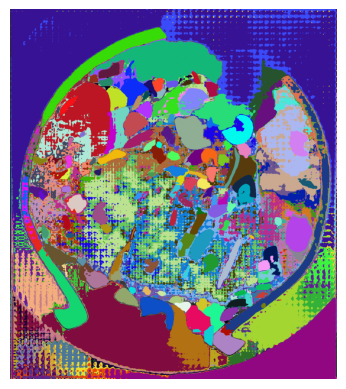

 Sauvegarde: sam_colored_slice_867.png


In [29]:

if len(masks) == 0:
    print(" Aucun objet détecté ")
else:
    masks_sorted = sorted(masks, key=lambda x: x.sum(), reverse=True)
    colored = colorize_masks(sl, masks_sorted, seed=0)
    plt.imshow(colored)
    plt.axis("off")
    plt.show()
    cv2.imwrite(f"sam_colored_slice_{mid}.png", colored)
    print(f" Sauvegarde: sam_colored_slice_{mid}.png")


### WRITE CODECARBONE RESULTS AND STOP TRACKER

In [30]:
emissions= tracker.stop()
with open("emissions.csv", "a", newline="") as f:
    writer = csv.writer(f)
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    writer.writerow([timestamp, emissions])


[codecarbon INFO @ 13:17:32] Energy consumed for RAM : 0.000634 kWh. RAM Power : 11.657401084899902 W
[codecarbon INFO @ 13:17:32] Energy consumed for all GPUs : 0.001363 kWh. Total GPU Power : 13.097 W
[codecarbon INFO @ 13:17:32] Energy consumed for all CPUs : 0.002312 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:17:32] 0.004308 kWh of electricity used since the beginning.
/home/thorrut/Documents/Funeria/test-funeria-env/.pixi/envs/default/lib/python3.10/site-packages/codecarbon/output.py:123: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame.from_records([dict(data.values)])])
